In [1]:
!pip install kaggle

In [2]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saurjyeshkarthikeyan","key":"99fcb4496dfdd09ab5f00f419aa328f6"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 64  # Resize to 64x64
X = []
y = []

base_path = 'leapGestRecog'

label_map = {}  # Gesture -> int
label_counter = 0

# Loop through each person directory
for person_dir in os.listdir(base_path):
    person_path = os.path.join(base_path, person_dir)
    if not os.path.isdir(person_path):
        continue

    for gesture in os.listdir(person_path):
        gesture_path = os.path.join(person_path, gesture)
        if gesture not in label_map:
            label_map[gesture] = label_counter
            label_counter += 1

        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label_map[gesture])

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = to_categorical(y, num_classes=len(label_map))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 171ms/step - accuracy: 0.7681 - loss: 0.7124 - val_accuracy: 0.9970 - val_loss: 0.0213
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 164ms/step - accuracy: 0.9945 - loss: 0.0204 - val_accuracy: 0.9948 - val_loss: 0.0106
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 7.8107e-05
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 161ms/step - accuracy: 0.9967 - loss: 0.0112 - val_accuracy: 0.9998 - val_loss: 0.0016
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - accuracy: 0.9988 - loss: 0.0035 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9937 - val_loss: 0.0144
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.9989 - l

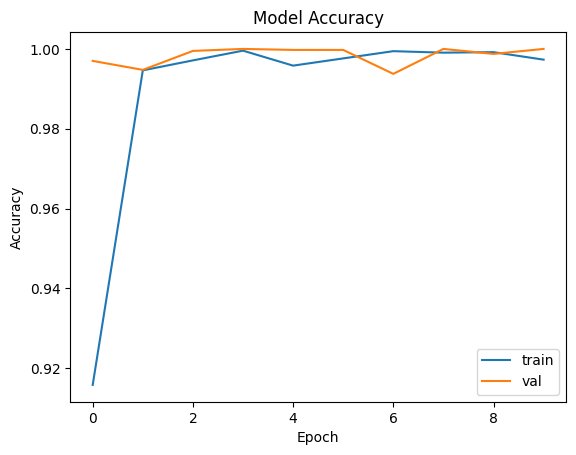

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()